In [1]:
import sys

sys.path.insert(0, '..')

In [55]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names, sep=' ', skipinitialspace=True, comment='\t', na_values='?')
df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [16]:
print(df.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


In [17]:
import sklearn
import sklearn.model_selection

df_train, df_test = sklearn.model_selection.train_test_split(df, train_size=.8, random_state=1)

stats = df_train.describe()
stats

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,318.000000,318.000000,318.000000,312.000000,318.000000,318.000000,318.000000,318.00000
mean,23.583962,5.418239,191.128931,103.317308,2952.047170,15.717610,75.921384,1.58805
std,7.890750,1.682508,102.212399,37.839804,836.500568,2.751966,3.683467,0.80815
min,9.000000,3.000000,70.000000,46.000000,1613.000000,8.500000,70.000000,1.00000
25%,17.500000,4.000000,101.750000,75.000000,2220.750000,14.000000,73.000000,1.00000
50%,23.000000,4.000000,146.000000,92.000000,2801.000000,15.500000,76.000000,1.00000
75%,29.800000,6.000000,258.000000,122.750000,3533.750000,17.400000,79.000000,2.00000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.00000


In [42]:
from sklearn.preprocessing import StandardScaler

temp_col_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']

df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

for col in temp_col_names:
    mean = stats.loc['mean', col]
    std = stats.loc['std', col]
    df_train_norm[col] = (df_train[col] - mean) / std
    df_test_norm[col] = (df_test[col] - mean) / std

df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,-0.842931,-0.500222,-0.457648,-0.193720,-0.042737,82,1
255,25.1,-0.842931,-0.500222,-0.404794,-0.277402,-0.115412,78,1
72,15.0,1.534472,1.104280,1.233693,1.123673,-1.169204,72,1
235,26.0,-0.842931,-0.920915,-0.748347,-0.821335,0.902042,77,3
37,18.0,0.345770,0.399864,-0.087667,0.401617,-0.079074,71,1


In [ ]:
boundaries = torch.tensor([73, 76, 79])

v = torch.tensor(df_train_norm['Model Year'].values)
df_train_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries=boundaries, right=True)

v = torch.tensor(df_test_norm['Model Year'].values)
df_test_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries=boundaries, right=True)

temp_col_names.append('Model Year Bucketed')

318

In [52]:
from torch.nn.functional import one_hot

total_origin = df_train['Origin'].nunique()

origin_encoded = one_hot(torch.from_numpy(df_train_norm['Origin'].values) % total_origin)
x_train_numeric = torch.tensor(df_train_norm[temp_col_names].values)
x_train = torch.cat([x_train_numeric, origin_encoded], 1).float()

origin_encoded = one_hot(torch.from_numpy(df_test_norm['Origin'].values) % total_origin)
x_test_numeric = torch.tensor(df_test_norm[temp_col_names].values)
x_test = torch.cat([x_test_numeric, origin_encoded], 1).float()

In [ ]:
y_train = torch.tensor(df_train['MPG'].values).float()
y_test = torch.tensor(df_test['MPG'].values).float()

x = len(x_train)
y = len(y_train) 

print(x)
print(y)

318
318


In [47]:
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(1)

batch_size = 8
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [50]:
hidden_units = [8, 4]
input_size = x_train.shape[1]

all_layers = []
for unit in hidden_units:
    layer = nn.Linear(in_features=input_size, out_features=unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = unit

all_layers.append(nn.Linear(in_features=hidden_units[-1], out_features=1))

model = nn.Sequential(*all_layers)
model

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [51]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001)

In [ ]:
torch.manual_seed(1)

num_epochs = 200

train_accuracy_hist = [0.0] * num_epochs
test_accuracy_hist = [0.0] * num_epochs
epoch_nums = [i for i in range(num_epochs)]

for epoch in range(num_epochs):
    epoch_train_accuracy = 0
    epoch_test_accuracy = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # TO DO: trying to graph loss rn, actually graph accuracy

        epoch_train_accuracy += loss.item()

    epoch_train_accuracy /= (len(train_dl) / batch_size)
    
    pred = model(x_test)[:, 0]
    loss = loss_fn(pred, y_test)
    epoch_test_accuracy = loss.item()

    train_accuracy_hist[epoch] = epoch_train_accuracy
    test_accuracy_hist[epoch] = epoch_test_accuracy

: 

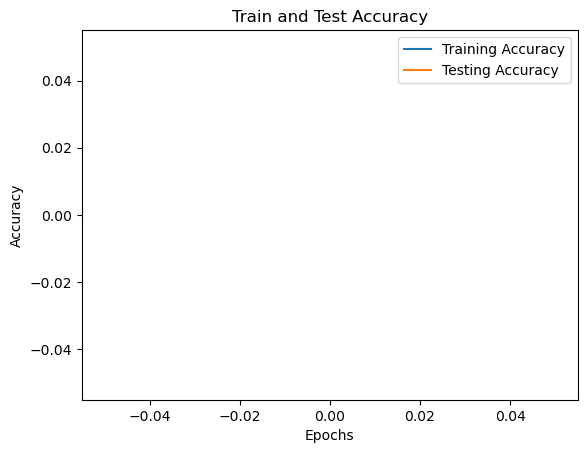

In [56]:
plt.title('Train and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.plot(epoch_nums, train_accuracy_hist, label='Training Accuracy')
plt.plot(epoch_nums, test_accuracy_hist, label='Testing Accuracy')
plt.legend()